In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install numpy pandas torch torchvision matplotlib scikit-learn

In [2]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
# load data

def load_glob(pattern):
    files = glob.glob(pattern)
    return pd.concat((pd.read_csv(f) for f in files), ignore_index=True)

df = load_glob("./data/2017_NYISO_LBMPs/**/*.csv")

In [4]:
df.head()

Time Stamp    Name   PTID  LBMP ($/MWHr)  \
0  07/04/2017 00:00  CAPITL  61757          22.90   
1  07/04/2017 00:00  CENTRL  61754          18.39   
2  07/04/2017 00:00  DUNWOD  61760          22.73   
3  07/04/2017 00:00  GENESE  61753          17.69   
4  07/04/2017 00:00     H Q  61844          17.27   

   Marginal Cost Losses ($/MWHr)  Marginal Cost Congestion ($/MWHr)  
0                           1.09                              -3.95  
1                           0.13                              -0.41  
2                           2.07                              -2.79  
3                          -0.48                              -0.31  
4                          -0.59                               0.00

In [5]:
df['Time Stamp']

0         07/04/2017 00:00
1         07/04/2017 00:00
2         07/04/2017 00:00
3         07/04/2017 00:00
4         07/04/2017 00:00
                ...       
131395    12/04/2017 23:00
131396    12/04/2017 23:00
131397    12/04/2017 23:00
131398    12/04/2017 23:00
131399    12/04/2017 23:00
Name: Time Stamp, Length: 131400, dtype: object

In [6]:
df['time_stamp'] = pd.to_datetime(df['Time Stamp'], format='%m/%d/%Y %H:%M')

In [7]:
df['time_stamp'].unique()

array(['2017-07-04T00:00:00.000000000', '2017-07-04T01:00:00.000000000',
       '2017-07-04T02:00:00.000000000', ...,
       '2017-12-04T21:00:00.000000000', '2017-12-04T22:00:00.000000000',
       '2017-12-04T23:00:00.000000000'], dtype='datetime64[ns]')

In [8]:
# explore data
df.describe()

PTID  LBMP ($/MWHr)  Marginal Cost Losses ($/MWHr)  \
count  131400.000000  131400.000000                  131400.000000   
mean    61780.600000      27.648274                       0.996168   
std        39.234148      15.703783                       1.742066   
min     61752.000000       0.000000                     -20.130000   
25%     61755.000000      18.710000                      -0.170000   
50%     61759.000000      25.550000                       0.700000   
75%     61844.000000      33.060000                       2.080000   
max     61847.000000     262.680000                      20.140000   

       Marginal Cost Congestion ($/MWHr)  
count                      131400.000000  
mean                           -4.418926  
std                             9.777601  
min                          -181.230000  
25%                            -5.530000  
50%                            -0.770000  
75%                             0.000000  
max                            31.520000

In [9]:
df = df.sort_values(by=['time_stamp'])

In [10]:
def plot_data(df, figsize=None, names=None, time_between=None, include_dates=False):
    df = df.sort_values(by=['time_stamp'])
    if figsize is None:
        figsize = (64, 12)
    plt.figure(figsize=figsize)
    
    if time_between is not None:
        start, stop = pd.to_datetime(time_between[0]), pd.to_datetime(time_between[1])
        df = df[(df['time_stamp'] >= start) & (df['time_stamp'] <= stop)]
    
    if include_dates:
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.DayLocator())
        plt.gcf().autofmt_xdate()
    
    names = names if names is not None else list(df['Name'].unique())
    for name in names:
        part = df[df['Name'] == name]
        plt.plot(part['time_stamp'], part['LBMP ($/MWHr)'])
    plt.legend(names)
    plt.show()

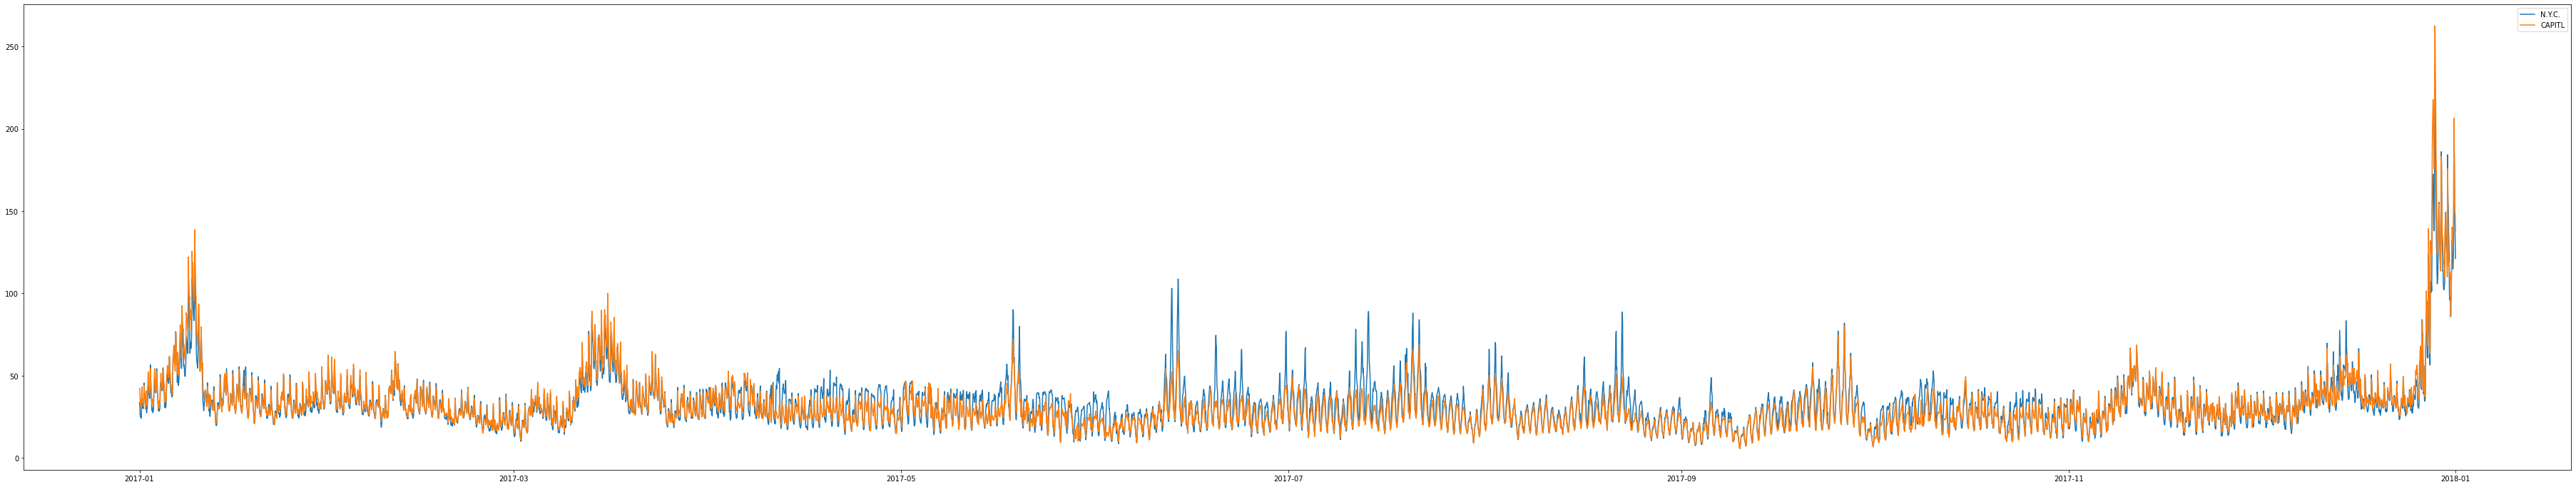

In [11]:
plot_data(df=df, names=['N.Y.C.', 'CAPITL'])

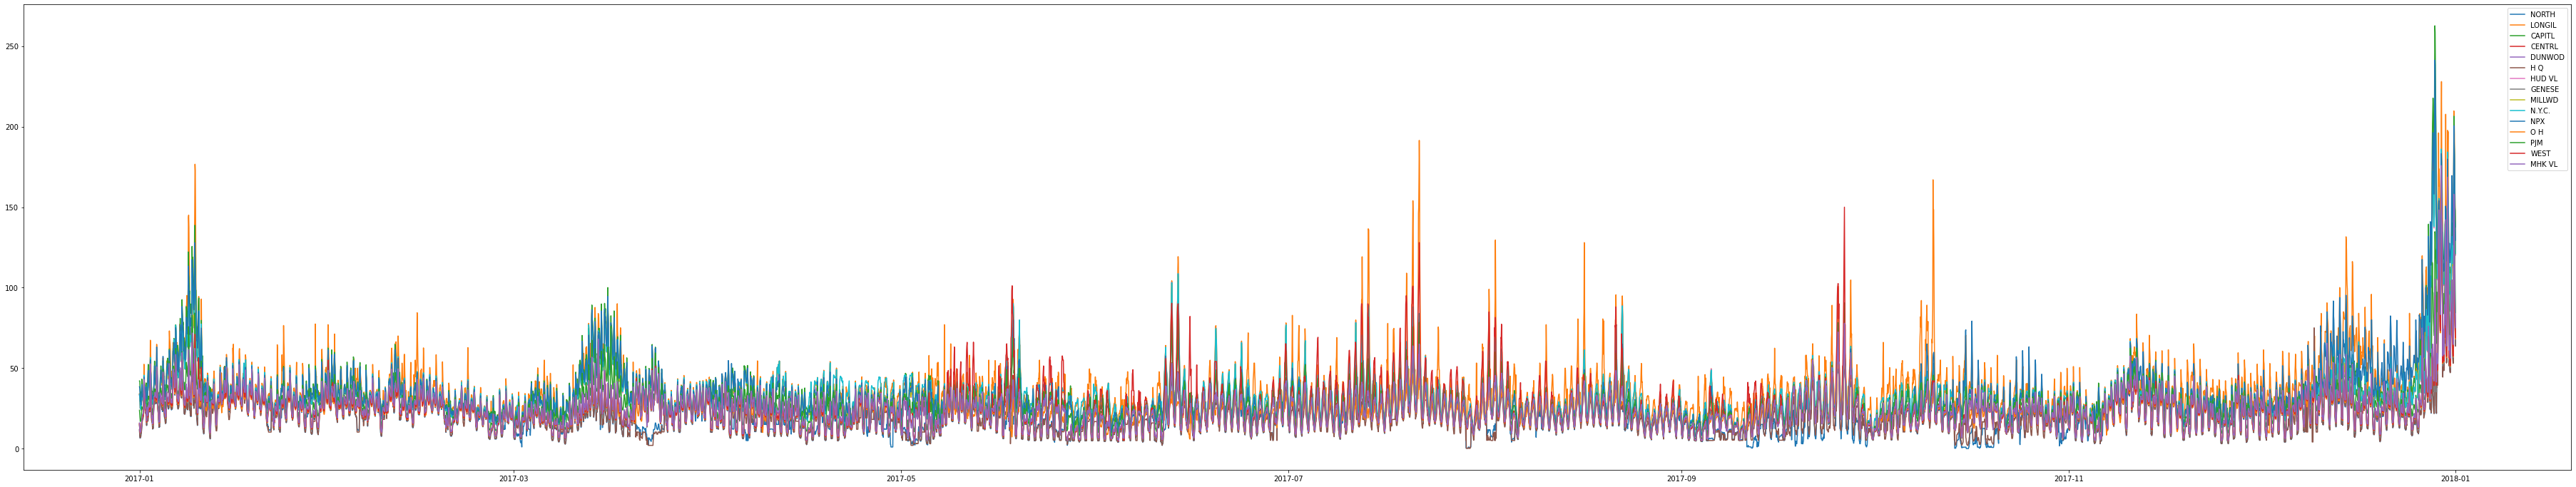

In [12]:
plot_data(df=df)

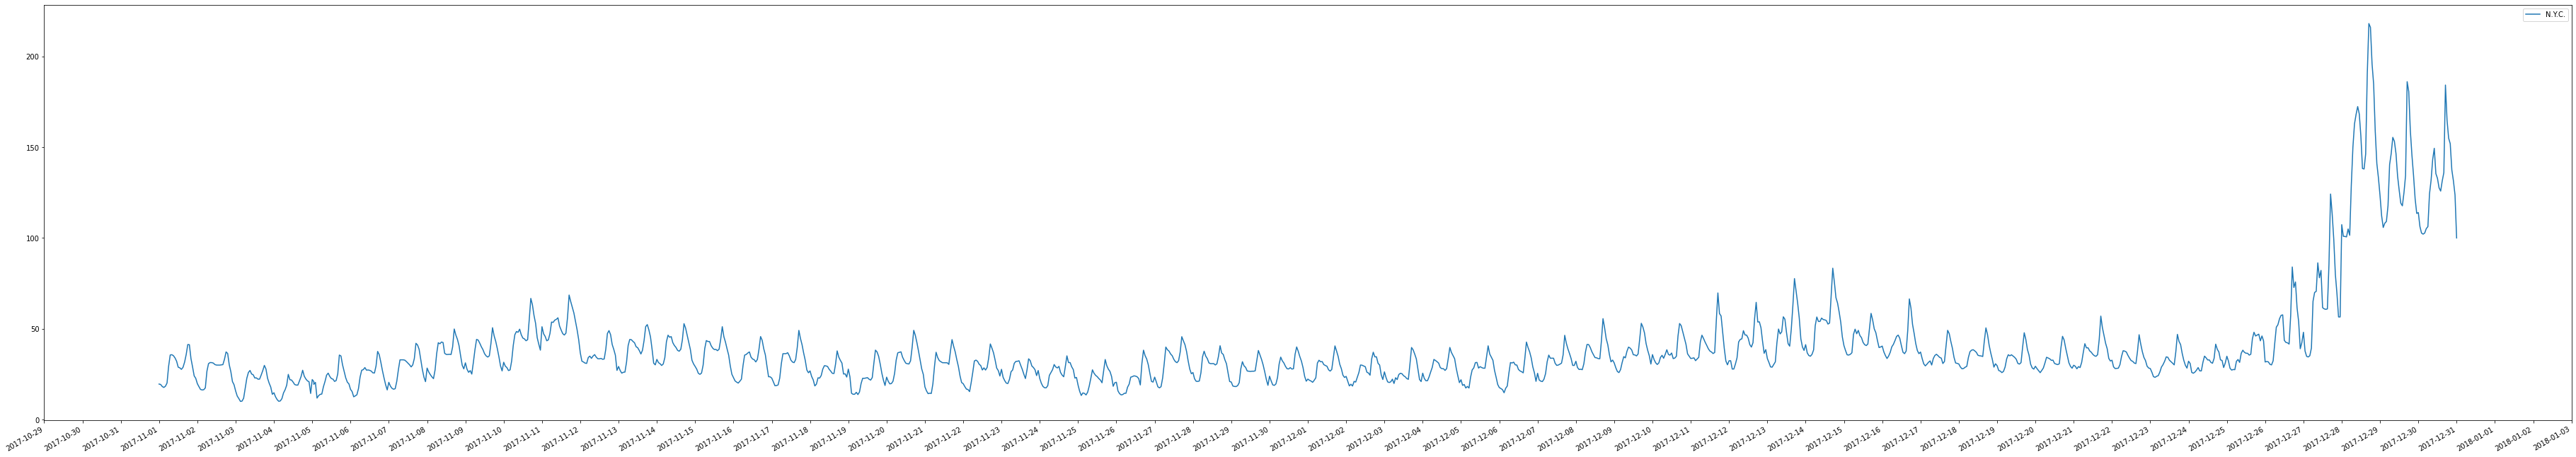

In [13]:
plot_data(df=df, figsize=(64, 12), names=['N.Y.C.'], include_dates=True, time_between=['2017-11-01 00:00', '2017-12-31 00:00'])

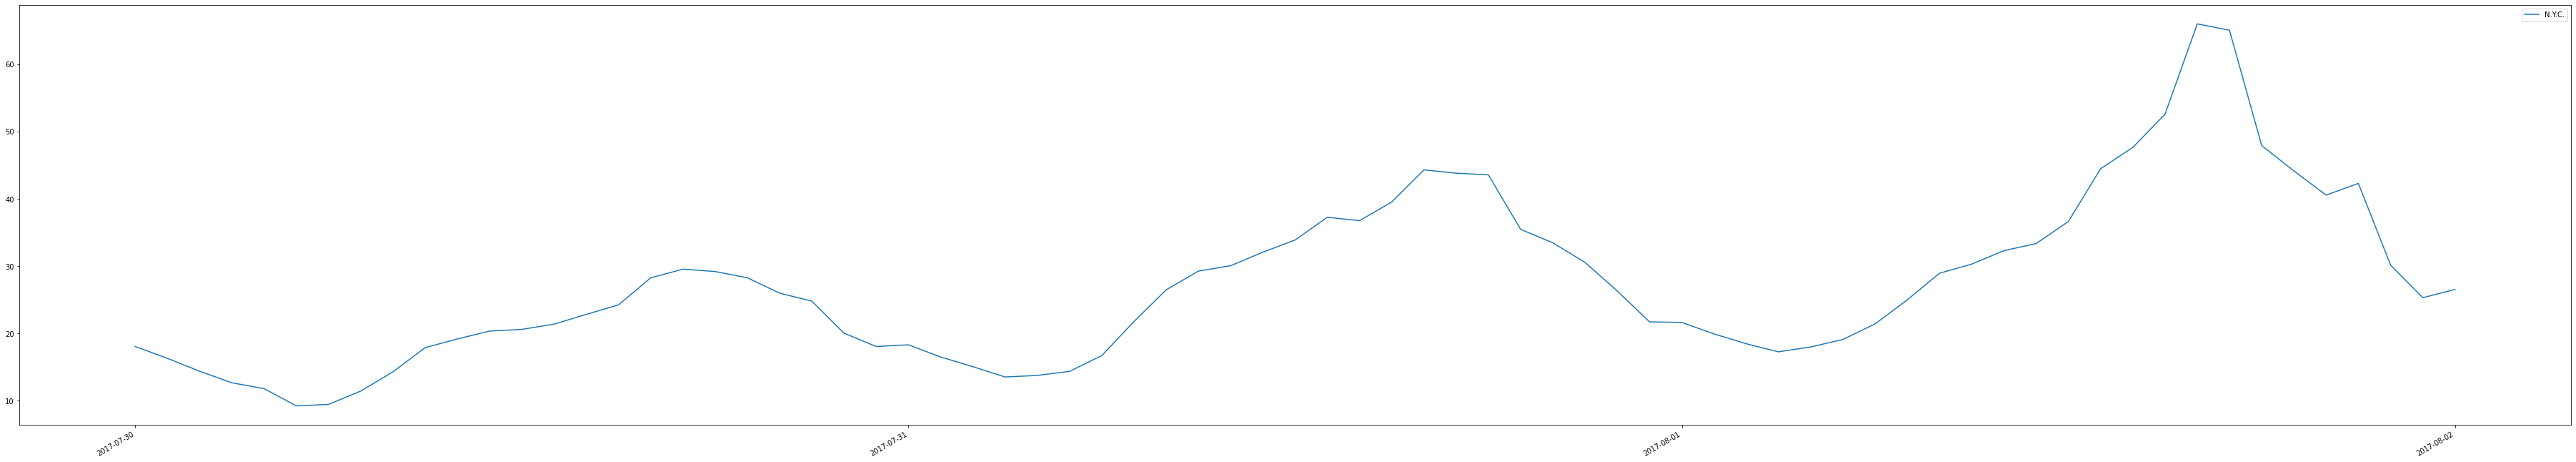

In [14]:
plot_data(df=df, figsize=(64, 12), names=['N.Y.C.'], include_dates=True, time_between=['2017-07-30 00:00', '2017-08-02 00:00'])

In [15]:
nyc = df[df['Name'] == 'N.Y.C.']
nyc.head()

Time Stamp    Name   PTID  LBMP ($/MWHr)  \
70914  01/01/2017 00:00  N.Y.C.  61761          33.60   
70929  01/01/2017 01:00  N.Y.C.  61761          32.05   
70944  01/01/2017 02:00  N.Y.C.  61761          29.23   
70959  01/01/2017 03:00  N.Y.C.  61761          25.02   
70974  01/01/2017 04:00  N.Y.C.  61761          26.94   

       Marginal Cost Losses ($/MWHr)  Marginal Cost Congestion ($/MWHr)  \
70914                           1.21                             -20.07   
70929                           0.81                             -22.89   
70944                           0.65                             -21.65   
70959                           0.67                             -17.41   
70974                           0.66                             -19.02   

               time_stamp  
70914 2017-01-01 00:00:00  
70929 2017-01-01 01:00:00  
70944 2017-01-01 02:00:00  
70959 2017-01-01 03:00:00  
70974 2017-01-01 04:00:00

In [16]:
# preprocess
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
y = nyc[['LBMP ($/MWHr)']]
y['scaled_lbmp'] = scaler.fit_transform(y['LBMP ($/MWHr)'].values.reshape(-1,1))
y = y[['scaled_lbmp']]
y.head()

/var/folders/1m/clk0pq4d2v524wngfdmlkh7r0000gn/T/ipykernel_95973/3908469133.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['scaled_lbmp'] = scaler.fit_transform(y['LBMP ($/MWHr)'].values.reshape(-1,1))


scaled_lbmp
70914    -0.738307
70929    -0.752908
70944    -0.779473
70959    -0.819132
70974    -0.801046

In [17]:
# create windows

def create_windows(df, window_size):
    df_np = df.to_numpy()
    windowed = [] 
    for i in range(len(df_np) - window_size):
        window = df_np[i:i + window_size]
        windowed.append(window)
    return np.array(windowed)

windowed = create_windows(df=y, window_size=48)
windowed.shape

(8712, 48, 1)

In [18]:
# split data

def split_data(data, test_size):
    # todo validate inputs -> test_size [0, 1]
    test_len = round(len(data) * test_size)
    train_len = len(data) - test_len
    X_train = data[:train_len,:-1,:]
    y_train = data[:train_len,-1,:]
    X_test = data[train_len:,:-1]
    y_test = data[train_len:,-1,:]
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(data=windowed, test_size=0.2)

In [19]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6970, 47, 1), (1742, 47, 1), (6970, 1), (1742, 1))

In [20]:
import torch
import torch.nn as nn

X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [21]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        init_hidden_state = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        output, (hn) = self.gru(x, (init_hidden_state.detach()))
        return self.linear(output[:, -1, :]) 

In [22]:
epochs = 100
input_size = 1
hidden_size = 64
num_layers = 2
output_size = 1

In [23]:
model = GRU(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.003)

In [24]:
losses = list(range(epochs))

for epoch in range(epochs):
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    print(f"Epoch {epoch + 1}/{epochs}, loss: {loss.item()}")
    losses[epoch] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

Epoch 1/100, loss: 0.38414266705513
Epoch 2/100, loss: 0.20905137062072754
Epoch 3/100, loss: 0.07815872877836227
Epoch 4/100, loss: 0.012639590539038181
Epoch 5/100, loss: 0.053354885429143906
Epoch 6/100, loss: 0.07651367783546448
Epoch 7/100, loss: 0.04597465321421623
Epoch 8/100, loss: 0.018446961417794228
Epoch 9/100, loss: 0.011478157714009285
Epoch 10/100, loss: 0.017764773219823837
Epoch 11/100, loss: 0.026937110349535942
Epoch 12/100, loss: 0.03289077803492546
Epoch 13/100, loss: 0.03377991169691086
Epoch 14/100, loss: 0.030281754210591316
Epoch 15/100, loss: 0.02420950122177601
Epoch 16/100, loss: 0.01771346479654312
Epoch 17/100, loss: 0.012772668153047562
Epoch 18/100, loss: 0.010720853693783283
Epoch 19/100, loss: 0.011758984066545963
Epoch 20/100, loss: 0.014714306220412254
Epoch 21/100, loss: 0.017511490732431412
Epoch 22/100, loss: 0.018396377563476562
Epoch 23/100, loss: 0.017002347856760025
Epoch 24/100, loss: 0.0143112288787961
Epoch 25/100, loss: 0.01173429004848003

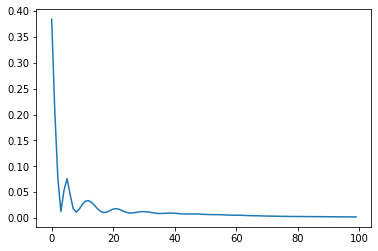

In [25]:
import matplotlib.pyplot as plt

plt.plot(losses)

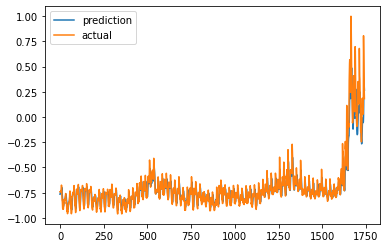

In [26]:
with torch.no_grad():
    prediction = model(X_test)
    plt.plot(prediction)
    plt.plot(y_test)
    plt.legend(['prediction', 'actual'])
    plt.show()

In [27]:
evaluation = pd.DataFrame(prediction.numpy())
evaluation.columns = ['predicted']
evaluation['actual'] = y_test.numpy()
evaluation.head()

predicted    actual
0  -0.765855 -0.740945
1  -0.753908 -0.745184
2  -0.749114 -0.741698
3  -0.746556 -0.740756
4  -0.745194 -0.741227

In [28]:
evaluation['error'] = evaluation.apply(lambda x: abs(abs(x['predicted']) - abs(x['actual'])), axis=1)
evaluation.head()

predicted    actual     error
0  -0.765855 -0.740945  0.024910
1  -0.753908 -0.745184  0.008724
2  -0.749114 -0.741698  0.007416
3  -0.746556 -0.740756  0.005800
4  -0.745194 -0.741227  0.003966

In [29]:
evaluation['error'].mean()

0.043543663

In [30]:
evaluation['error'].describe()

count    1742.000000
mean        0.043544
std         0.062625
min         0.000012
25%         0.012072
50%         0.027920
75%         0.052700
max         0.804300
Name: error, dtype: float64

In [31]:
nyc['LBMP ($/MWHr)'].describe()

count    8760.000000
mean       33.154580
std        16.655716
min         5.820000
25%        23.700000
50%        30.990000
75%        38.440000
max       218.130000
Name: LBMP ($/MWHr), dtype: float64

In [44]:
# predict
fake_data = pd.DataFrame({})
fake_data['time_stamp'] = pd.date_range(start='2017-05-05 00:00', periods=48, freq='H')
fake_data['lbmp'] = np.random.normal(33.15, 16.65, 48)
fake_data['lbmp'] = np.where(fake_data['lbmp'] < 5, 5, fake_data['lbmp'])
fake_data.head()

time_stamp       lbmp
0 2017-05-05 00:00:00  47.335440
1 2017-05-05 01:00:00  54.988879
2 2017-05-05 02:00:00  28.843550
3 2017-05-05 03:00:00  28.639397
4 2017-05-05 04:00:00   5.000000

In [45]:
fake_data['lbmp'].describe()

count    48.000000
mean     31.838148
std      13.131624
min       5.000000
25%      26.459774
50%      33.266646
75%      39.349060
max      55.298302
Name: lbmp, dtype: float64

In [46]:
fake_data['scaled_lbmp'] = scaler.transform(fake_data['lbmp'].values.reshape(-1,1))
fake_data.head()

time_stamp       lbmp  scaled_lbmp
0 2017-05-05 00:00:00  47.335440    -0.608917
1 2017-05-05 01:00:00  54.988879    -0.536820
2 2017-05-05 02:00:00  28.843550    -0.783114
3 2017-05-05 03:00:00  28.639397    -0.785037
4 2017-05-05 04:00:00   5.000000    -1.007725

In [47]:
t = torch.from_numpy(fake_data['scaled_lbmp'].to_numpy()).type(torch.Tensor).reshape(1, 48, 1)

In [48]:
predicted = model(t)
predicted

tensor([[-0.7513]], grad_fn=<AddmmBackward0>)

In [49]:
transformed_pred = scaler.inverse_transform(predicted.detach().numpy())
transformed_pred[0][0]

32.219307

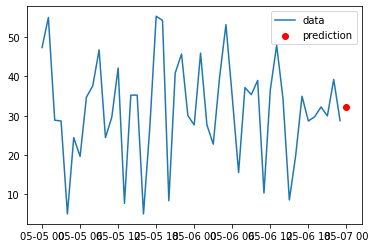

In [50]:
plt.plot(fake_data['time_stamp'], fake_data['lbmp'])
plt.scatter([pd.to_datetime('2017-05-07 00:00:00')], [transformed_pred], color="red")
plt.legend(['data', 'prediction'])
plt.show()

In [51]:
# 2 days prediction
t2 = torch.cat((t, predicted.unsqueeze(dim=1)), dim=1)
t2.shape

torch.Size([1, 49, 1])

In [52]:
predicted2 = model(t2)
predicted2

tensor([[-0.7562]], grad_fn=<AddmmBackward0>)

In [53]:
transformed_pred2 = scaler.inverse_transform(predicted2.detach().numpy())
transformed_pred2[0][0]

31.699657

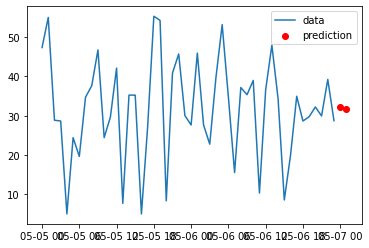

In [55]:
plt.plot(fake_data['time_stamp'], fake_data['lbmp'])
plt.scatter(
    [pd.to_datetime('2017-05-07 00:00:00'), pd.to_datetime('2017-05-07 01:00:00')],
    [transformed_pred, transformed_pred2],
    color="red"
)
plt.legend(['data', 'prediction'])
plt.show()

In [107]:
part = nyc[(nyc['time_stamp'] < '2017-08-01 00:00')]
part = part.sort_values(by='time_stamp')
part.head()

Time Stamp    Name   PTID  LBMP ($/MWHr)  \
70914  01/01/2017 00:00  N.Y.C.  61761          33.60   
70929  01/01/2017 01:00  N.Y.C.  61761          32.05   
70944  01/01/2017 02:00  N.Y.C.  61761          29.23   
70959  01/01/2017 03:00  N.Y.C.  61761          25.02   
70974  01/01/2017 04:00  N.Y.C.  61761          26.94   

       Marginal Cost Losses ($/MWHr)  Marginal Cost Congestion ($/MWHr)  \
70914                           1.21                             -20.07   
70929                           0.81                             -22.89   
70944                           0.65                             -21.65   
70959                           0.67                             -17.41   
70974                           0.66                             -19.02   

               time_stamp  
70914 2017-01-01 00:00:00  
70929 2017-01-01 01:00:00  
70944 2017-01-01 02:00:00  
70959 2017-01-01 03:00:00  
70974 2017-01-01 04:00:00

In [108]:
part.tail()

Time Stamp    Name   PTID  LBMP ($/MWHr)  \
1374  07/31/2017 19:00  N.Y.C.  61761          35.47   
1389  07/31/2017 20:00  N.Y.C.  61761          33.47   
1404  07/31/2017 21:00  N.Y.C.  61761          30.56   
1419  07/31/2017 22:00  N.Y.C.  61761          26.31   
1434  07/31/2017 23:00  N.Y.C.  61761          21.73   

      Marginal Cost Losses ($/MWHr)  Marginal Cost Congestion ($/MWHr)  \
1374                           3.65                              -1.60   
1389                           3.45                              -1.76   
1404                           3.41                              -0.73   
1419                           2.83                              -2.70   
1434                           2.41                              -0.35   

              time_stamp  
1374 2017-07-31 19:00:00  
1389 2017-07-31 20:00:00  
1404 2017-07-31 21:00:00  
1419 2017-07-31 22:00:00  
1434 2017-07-31 23:00:00

In [145]:
y = part[['LBMP ($/MWHr)']]
y['scaled_lbmp'] = scaler.transform(y['LBMP ($/MWHr)'].values.reshape(-1, 1))
y = y[['scaled_lbmp']]
y.head()
y['scaled_lbmp'].describe()

/var/folders/1m/clk0pq4d2v524wngfdmlkh7r0000gn/T/ipykernel_95973/2347826804.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['scaled_lbmp'] = scaler.transform(y['LBMP ($/MWHr)'].values.reshape(-1, 1))


count    5087.000000
mean       -0.738172
std         0.121788
min        -0.973435
25%        -0.818944
50%        -0.752155
75%        -0.682728
max         0.048278
Name: scaled_lbmp, dtype: float64

In [147]:
windowed = create_windows(y, 48)
windowed.shape
windowed[0]
# t3 = torch.from_numpy(windowed).type(torch.Tensor)
# t3.shape

array([[-0.73830719],
       [-0.75290848],
       [-0.77947341],
       [-0.8191324 ],
       [-0.80104564],
       [-0.81348029],
       [-0.82845839],
       [-0.79708916],
       [-0.76675616],
       [-0.72135085],
       [-0.75808959],
       [-0.76798078],
       [-0.75545193],
       [-0.77259667],
       [-0.77146625],
       [-0.77137205],
       [-0.72229287],
       [-0.62583015],
       [-0.66925722],
       [-0.68178607],
       [-0.70298149],
       [-0.72003203],
       [-0.75488672],
       [-0.7740097 ],
       [-0.71419151],
       [-0.72445952],
       [-0.77090104],
       [-0.79718336],
       [-0.77316189],
       [-0.77316189],
       [-0.75309689],
       [-0.71993783],
       [-0.68762658],
       [-0.64429372],
       [-0.68583675],
       [-0.6834817 ],
       [-0.68253968],
       [-0.69883661],
       [-0.71503933],
       [-0.70637276],
       [-0.64175027],
       [-0.52173708],
       [-0.58428713],
       [-0.62338091],
       [-0.67500353],
       [-0

In [116]:
predicted3 = model(t3)
predicted3

tensor([[-0.7617],
        [-0.7680],
        [-0.7713],
        ...,
        [-0.7263],
        [-0.7519],
        [-0.7808]], grad_fn=<AddmmBackward0>)

In [117]:
transformed_pred3 = scaler.inverse_transform(predicted3.detach().numpy())
transformed_pred3[0][0]

31.111456

In [137]:
transformed_pred3[-24:].shape

(24, 1)

In [96]:
# pd.date_range("2017-01-01", "2017-08-01 23:00:00", freq="1h")

DatetimeIndex(['2017-08-01 00:00:00', '2017-08-01 01:00:00',
               '2017-08-01 02:00:00', '2017-08-01 03:00:00',
               '2017-08-01 04:00:00', '2017-08-01 05:00:00',
               '2017-08-01 06:00:00', '2017-08-01 07:00:00',
               '2017-08-01 08:00:00', '2017-08-01 09:00:00',
               '2017-08-01 10:00:00', '2017-08-01 11:00:00',
               '2017-08-01 12:00:00', '2017-08-01 13:00:00',
               '2017-08-01 14:00:00', '2017-08-01 15:00:00',
               '2017-08-01 16:00:00', '2017-08-01 17:00:00',
               '2017-08-01 18:00:00', '2017-08-01 19:00:00',
               '2017-08-01 20:00:00', '2017-08-01 21:00:00',
               '2017-08-01 22:00:00', '2017-08-01 23:00:00'],
              dtype='datetime64[ns]', freq='H')

In [144]:
predictions = [item.item() for item in transformed_pred3[-24:]]
predictions

[21.506668090820312,
 20.62856101989746,
 19.648887634277344,
 18.524900436401367,
 17.311180114746094,
 16.857698440551758,
 17.04215431213379,
 18.2656192779541,
 21.233060836791992,
 24.928905487060547,
 27.935260772705078,
 29.555007934570312,
 30.986730575561523,
 32.443992614746094,
 34.62567901611328,
 35.55245590209961,
 37.00084686279297,
 39.87649154663086,
 41.27898406982422,
 41.59694290161133,
 38.08757781982422,
 34.87159729003906,
 32.15837478637695,
 29.086633682250977]

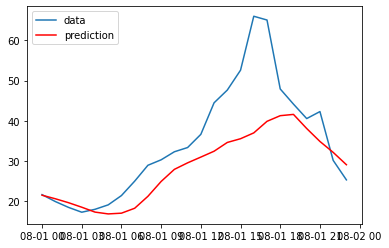

24

In [143]:
# part2 = nyc[(nyc['time_stamp'] >= '2017-08-01 00:00') & (nyc['time_stamp'] < '2017-08-02 00:00')]
# all_ = pd.concat([part, part2.sort_values(by='time_stamp')])
sliced = nyc[(nyc['time_stamp'] >= '2017-08-01 00:00:00') & (nyc['time_stamp'] < '2017-08-02 00:00:00')]
plt.plot(sliced['time_stamp'], sliced['LBMP ($/MWHr)'])
plt.plot(
    pd.date_range("2017-08-01 00:00:00", "2017-08-01 23:00:00", freq="1h"),
    predictions,
    color="red"
)
plt.legend(['data', 'prediction'])
plt.show()
len(sliced)

In [87]:
windowed = create_windows(df=y, window_size=48)
windowed

# with torch.no_grad():
#     prediction = model(X_test)
#     plt.plot(prediction)
#     plt.plot(y_test)
#     plt.legend(['prediction', 'actual'])
#     plt.show()

array([[[-0.8846027 ],
        [-0.90118223],
        [-0.91917479],
        [-0.93537751],
        [-0.94357308],
        [-0.96768876],
        [-0.96571052],
        [-0.94696434],
        [-0.92011681],
        [-0.88620414],
        [-0.87405209],
        [-0.86303047],
        [-0.86067543],
        [-0.85332768],
        [-0.83966841],
        [-0.82638595],
        [-0.78851679],
        [-0.77636475],
        [-0.77966182],
        [-0.78842259],
        [-0.80990062],
        [-0.82111064],
        [-0.86595073],
        [-0.8846027 ]],

       [[-0.90118223],
        [-0.91917479],
        [-0.93537751],
        [-0.94357308],
        [-0.96768876],
        [-0.96571052],
        [-0.94696434],
        [-0.92011681],
        [-0.88620414],
        [-0.87405209],
        [-0.86303047],
        [-0.86067543],
        [-0.85332768],
        [-0.83966841],
        [-0.82638595],
        [-0.78851679],
        [-0.77636475],
        [-0.77966182],
        [-0.78842259],
        [

In [106]:
len(cp)
t_ = torch.from_numpy(cp['scaled_lbmp'].to_numpy()).type(torch.Tensor).reshape(1, y.shape[0], 1)
t_.shape
pred_ = model(t_)
transformed_ = scaler.inverse_transform(pred_.detach().numpy())
transformed_
# for i in range(24):
#     t_ = torch.from_numpy(cp['scaled_lbmp'].to_numpy()).type(torch.Tensor).reshape(1, y.shape[0], 1)
#     pred_ = model(t_)
#     transformed_ = scaler.inverse_transform(pred_.detach().numpy())
#     predictions.append(transformed_)
#     cp = cp.append({'scaled_lbmp': pred_.item()}, ignore_index=True)
#     cp = cp.tail(120)

array([[30.586489]], dtype=float32)